# Class Project 2 – Predictive Modeling

The Consumer Financial Protection Bureau (CFPB) is a U.S. government agency that makes sure financial companies treat their customers fairly. Their website allows customers of financial services to file complaints against financial companies and banks against unfair treatment if these companies are unable to resolve complaints to the customer’s satisfaction.
 
When customers choose to complain to the CFPB, financial companies incur additional costs to resolve such complaints.

On receipt, the CFPB routes complaints to the financial companies, who generally respond to the consumer within 15 days.  Once a response is provided, one of two things can happen:

1.	In most cases, consumers accept the response or remediation offered by the financial companies, 

2.	In other cases, they choose to dispute the resolution offered by the company.  (flagged in the 'Consumer disputed?' field).  In these situations, the bank has to perform additional investigations, and possibly offer further relief to the customers.  As a result, the cost of dealing with disputes can be high.

The original dataset for this project has over 2 million anonymized recent records, and covers 6000+ financial providers of all varieties.  It can be downloaded following the instructions at https://www.consumerfinance.gov/data-research/consumer-complaints/.  The website also provides additional information on the data, including the data dictionary.  

For this project, we will use only the data till 2017, and only for the top 5 banks in the US.  In order to make sure we are all working off the same data, we will use the file complaints_25Nov21.csv available in Jupyterhub under the **shared/ folder**.


The cost structure:

1.	On average, it costs the banks $100 to resolve, respond to and close a complaint that is not disputed.

2.	On the other hand, it costs banks an extra $500 to resolve a complaint if it has been disputed.  (This $500 is on top of the $100 they have already spent.)

3.	Extra diligence: If the banks know in advance which complaints will be disputed, they can perform “extra diligence” during the first round of addressing the complaint with a view to avoiding eventual disputes.  Performing extra diligence costs $90 per complaint, and provides a guarantee that the customer will not dispute the complaint.  But performing the extra diligence is wasted money if the customer would not have disputed the complaint.

You are required to create a model that can help the banks identify complaints that will end in a dispute.  The goal is to minimize total financial costs, and if the banks can identify future disputes they can avoid the larger costs by performing the cheaper extra diligence in advance.

Hint: Think about Calculating Total Cost in Dollars    
•	The moment a complaint enters the CFPB’s system, there is $100 cost to resolve it.  This applies to every complaint.

•	After that, if a complaint’s resolution is disputed by the customer, an additional \$500 has to be spent (for a total cost for such cases to be $600).

•	But the bank can intervene in advance by spending an extra $90 for extra diligence, and that can make sure the complaint’s resolution is not disputed. 

While we can’t prevent complaints from coming to the CFPB, we can reduce total costs by identifying the complaints that are likely to be disputed, and doing the extra due diligence for them.  This extra due diligence will cost us an extra \$90 per complaint, but save us the additional \$500 to resolve the complaint after the dispute.  But obviously, the bank would not want to spend this extra money on complaints that would not have been disputed anyway.

Your task is to create a predictive model that can help the banks keep their total complaint related costs low.  

Follow the instructions below and answer the multiple choice questions that follow.

## 1. 	Explore the data, familiarize yourself with the fields and perform some EDA.

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import phik
from IPython.display import Markdown as md

In [29]:
df = pd.read_csv("shared/complaints_25Nov21.csv")
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2016-10-26,Money transfers,International money transfer,Other transaction issues,NaN,"To whom it concerns, I would like to file a fo...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NaN,NaN,NaN,Consent provided,Web,2016-10-29,Closed with explanation,Yes,No,2180490
1,2015-03-27,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,My name is XXXX XXXX XXXX and huband name is X...,Company chooses not to provide a public response,"CITIBANK, N.A.",PA,151XX,Older American,Consent provided,Web,2015-03-27,Closed with explanation,Yes,No,1305453
2,2015-04-20,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",NaN,XXXX 2015 : I called to make a payment on XXXX...,Company chooses not to provide a public response,U.S. BANCORP,PA,152XX,NaN,Consent provided,Web,2015-04-22,Closed with monetary relief,Yes,No,1337613
3,2013-04-29,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,NaN,JPMORGAN CHASE & CO.,VA,22406,Servicemember,NaN,Phone,2013-04-30,Closed with explanation,Yes,Yes,393900
4,2013-05-29,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30044,NaN,NaN,Referral,2013-05-31,Closed with explanation,Yes,No,418647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207255,2015-05-24,Debt collection,Credit card,Taking/threatening an illegal action,Sued w/o proper notification of suit,NaN,NaN,JPMORGAN CHASE & CO.,FL,33133,NaN,Consent not provided,Web,2015-05-24,Closed with explanation,Yes,No,1390395
207256,2012-01-10,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,JPMORGAN CHASE & CO.,NY,10312,NaN,NaN,Referral,2012-01-11,Closed without relief,Yes,Yes,12192
207257,2012-07-17,Student loan,Non-federal student loan,Repaying your loan,NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",NH,032XX,NaN,NaN,Web,2012-07-18,Closed with explanation,Yes,No,118351
207258,2016-09-29,Bank account or service,Checking account,"Account opening, closing, or management",NaN,Near the end of XXXX 2016 I opened a Citigold ...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,900XX,NaN,Consent provided,Web,2016-09-29,Closed with non-monetary relief,Yes,No,2138969


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207260 entries, 0 to 207259
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 207260 non-null  object
 1   Product                       207260 non-null  object
 2   Sub-product                   164245 non-null  object
 3   Issue                         207260 non-null  object
 4   Sub-issue                     10347 non-null   object
 5   Consumer complaint narrative  29391 non-null   object
 6   Company public response       58458 non-null   object
 7   Company                       207260 non-null  object
 8   State                         205066 non-null  object
 9   ZIP code                      197974 non-null  object
 10  Tags                          28265 non-null   object
 11  Consumer consent provided?    51313 non-null   object
 12  Submitted via                 207260 non-null  object
 13 

In [31]:
# This identifies columns with missing values in each column.
missing_data = df.isnull().sum().sort_values(ascending = False)
missing_data

Sub-issue                       196913
Tags                            178995
Consumer complaint narrative    177869
Consumer consent provided?      155947
Company public response         148802
Sub-product                      43015
ZIP code                          9286
State                             2194
Date sent to company                 0
Consumer disputed?                   0
Timely response?                     0
Company response to consumer         0
Date received                        0
Submitted via                        0
Product                              0
Company                              0
Issue                                0
Complaint ID                         0
dtype: int64

In [32]:
df = df.fillna('missing')

In [33]:
# This identifies columns with missing values in each column.
missing_data = df.isnull().sum().sort_values(ascending = False)
missing_data

Date received                   0
Product                         0
Consumer disputed?              0
Timely response?                0
Company response to consumer    0
Date sent to company            0
Submitted via                   0
Consumer consent provided?      0
Tags                            0
ZIP code                        0
State                           0
Company                         0
Company public response         0
Consumer complaint narrative    0
Sub-issue                       0
Issue                           0
Sub-product                     0
Complaint ID                    0
dtype: int64

## 2.	Set your X (predictor) and y (predicted) variables. 
a.	Use only the below variables as your predictors.  Ignore the other variables in the dataset.
'Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via',  'Company response to consumer', 'Timely response?'

b.	Use 'Consumer disputed?' as your y-variable.  Be sure to convert your y-variable to 0s and 1s so your model can use it.

In [34]:
from sklearn import preprocessing
X = df.loc[:, ['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via', 'Company response to consumer', 'Timely response?']]
X = pd.get_dummies(X)
le = preprocessing.LabelEncoder()
# Encode categorical variables
y = le.fit_transform(df['Consumer disputed?'])
y

array([0, 0, 0, ..., 0, 0, 0])

## 3.	Split your data into a test and train set.  Use an 80/20 train-test split, and random_state=123 for the train-test split. 

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

In [36]:
# We check the shape of our X and y 

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(165808, 234)
(165808,)
(41452, 234)
(41452,)


## 4.	Check what proportion of complaints in your training dataset are disputed.  If this proportion is less than 30%, use random undersampling with random_state = 123 to balance your dataset. 

In [37]:
from imblearn.under_sampling import RandomUnderSampler
dispute_proportion = y_train.mean()
print(y_train.mean())

if dispute_proportion < 0.3:
    # Apply random undersampling
    rus = RandomUnderSampler(random_state=123)
    X_train, y_train = rus.fit_resample(X, y)
y_train.mean()


0.21684719675769565


0.5

In [38]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(207260, 234)
(89806, 234)
(41452, 234)


In [39]:
# Let us look at what y_train looks like, and the value_counts()
pd.DataFrame(y_train).value_counts()

0    44903
1    44903
Name: count, dtype: int64

/opt/conda/envs/mggy8413/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

           0       0.85      0.53      0.66     32504
           1       0.28      0.65      0.39      8948

    accuracy                           0.56     41452
   macro avg       0.56      0.59      0.52     41452
weighted avg       0.73      0.56      0.60     41452



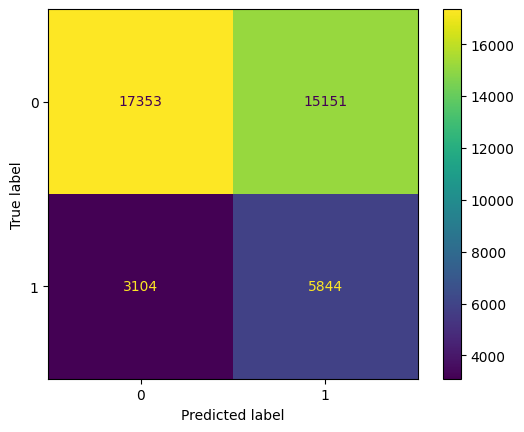

In [40]:
# Fit the model
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

model_xgb = XGBClassifier(use_label_encoder=False, objective= 'binary:logistic',random_state = 123)
#model_xgb = XGBClassifier(random_state = 123)
model_xgb.fit(X_train, y_train)

# Perform predictions, and store the results in a variable called 'pred'
pred = model_xgb.predict(X_test)

# Check the classification report and the confusion matrix
print(classification_report(y_true = y_test, y_pred = pred))
ConfusionMatrixDisplay.from_estimator(model_xgb, X_test, y_test);

### Calculate actual cost without model

In [41]:
# Calculate the number of disputed and non-disputed complaints
number_disputed = y_test.sum()
number_non_disputed = len(y_test) - number_disputed

# Calculate the total cost
total_cost = (number_disputed * 600) + (number_non_disputed * 100)
total_cost

8619200

### Based on model results, what would be the total cost to the banks of dealing with the complaints in the test set?
- If the model predicts the complaint will be disputed (prediction 1), the bank spends \$90 on extra diligence.
- If the model predicts the complaint will not be disputed (prediction 0), the cost is \$100.
- If the model incorrectly predicts a non-disputed complaint as disputed (false positive), the bank spends an unnecessary \$90.
- If the model incorrectly predicts a disputed complaint as non-disputed (false negative), the bank incurs the full \$600 cost.

In [42]:
# Predictions from the model
predictions = pred  # This should be the predictions array from the model

# Calculate costs based on the predictions
predicted_disputed = predictions == 1
predicted_non_disputed = predictions == 0
# Actual values
actual_disputed = y_test == 1
actual_non_disputed = y_test == 0

# True Positive + False Posotive: Model predicts disputed, diligence cost applies
print('TP+FP:',sum((predictions == 1) & (y_test == 1))+sum((predictions == 1) & (y_test == 0)))
diligence_cost = (sum((predictions == 1) & (y_test == 1))+sum((predictions == 1) & (y_test == 0))) * 190

# False Negative: Model predicts non-disputed, but it is actually disputed
fn_cost = sum((predictions == 0) & (y_test == 1)) * 600
print('FN:', sum((predictions == 0) & (y_test == 1)))

# True Negative: Model predicts non-disputed, and it is actually non-disputed
# Standard cost applies
tn_cost = sum((predictions == 0) & (y_test == 0)) * 100
print('TN:',sum((predictions == 0) & (y_test == 0)) )

# Calculate the total cost
total_cost_model = diligence_cost + fn_cost + tn_cost
total_cost_model

TP+FP: 20995
FN: 3104
TN: 17353


7586750

### Change results by varying threshold

In [43]:
# Look at how the probabilities look for the first 10 observations
# The first column is class 0, and the second column is class 1

model_xgb.predict_proba(X_test)[:10]

array([[0.34525168, 0.6547483 ],
       [0.55318874, 0.44681126],
       [0.53836995, 0.46163005],
       [0.82460964, 0.17539038],
       [0.6356379 , 0.36436215],
       [0.4250173 , 0.5749827 ],
       [0.45215088, 0.5478491 ],
       [0.46450043, 0.5354996 ],
       [0.44814914, 0.55185086],
       [0.46196222, 0.5380378 ]], dtype=float32)

In [44]:
y_test[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [45]:
# Let us round the above as to make it a bit easier to read...
# same thing as prior cell, just presentation
np.round(model_xgb.predict_proba(X_test)[:10], 3)

array([[0.345, 0.655],
       [0.553, 0.447],
       [0.538, 0.462],
       [0.825, 0.175],
       [0.636, 0.364],
       [0.425, 0.575],
       [0.452, 0.548],
       [0.465, 0.535],
       [0.448, 0.552],
       [0.462, 0.538]], dtype=float32)

In [46]:
# Now see what the actual prediction is for the first 10 items
# You can see the model has picked the most probable item
# for identifying which category it should be assigned.
#
# We can vary the threshold to change the predictions.
# We do this next

model_xgb.predict(X_test)[:10]

array([1, 0, 0, 0, 0, 1, 1, 1, 1, 1])

Confusion Matrix : 
 [[11614 20890]
 [ 1612  7336]]
Test accuracy =  0.4571552639197144
              precision    recall  f1-score   support

           0       0.88      0.36      0.51     32504
           1       0.26      0.82      0.39      8948

    accuracy                           0.46     41452
   macro avg       0.57      0.59      0.45     41452
weighted avg       0.74      0.46      0.48     41452

TP+FP: 28226
FN: 1612
TN: 11614
total_cost_model =  7491540


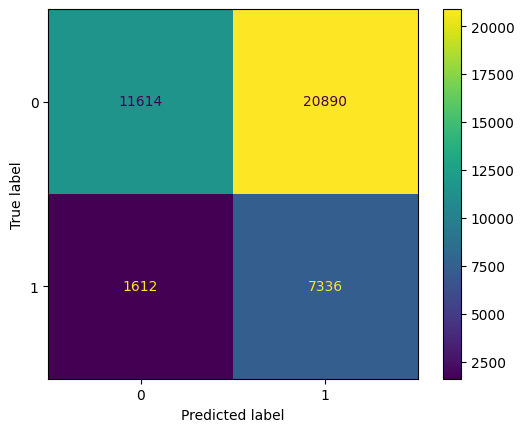

In [47]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Set threshold for identifying class 1
threshold = 0.46

# Create predictions.  Note that predictions give us probabilities, not classes!
pred_prob = model_xgb.predict_proba(X_test)

# We drop the probabilities for class 0, and keep just the second column
pred_prob = pred_prob[:,1]

# Convert probabilities to 1s and 0s based on threshold
pred = (pred_prob>threshold).astype(int)

# confusion matrix
cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, pred))
print(classification_report(y_true = y_test, y_pred = pred,))

# Predictions from the model
predictions = pred  # This should be the predictions array from the model

# Calculate costs based on the predictions
predicted_disputed = predictions == 1
predicted_non_disputed = predictions == 0
# Actual values
actual_disputed = y_test == 1
actual_non_disputed = y_test == 0

# True Positive + False Posotive: Model predicts disputed, diligence cost applies
print('TP+FP:',sum((predictions == 1) & (y_test == 1))+sum((predictions == 1) & (y_test == 0)))
diligence_cost = (sum((predictions == 1) & (y_test == 1))+sum((predictions == 1) & (y_test == 0))) * 190

# False Negative: Model predicts non-disputed, but it is actually disputed
fn_cost = sum((predictions == 0) & (y_test == 1)) * 600
print('FN:', sum((predictions == 0) & (y_test == 1)))

# True Negative: Model predicts non-disputed, and it is actually non-disputed
# Standard cost applies
tn_cost = sum((predictions == 0) & (y_test == 0)) * 100
print('TN:',sum((predictions == 0) & (y_test == 0)) )

# Calculate the total cost
total_cost_model = diligence_cost + fn_cost + tn_cost
total_cost_model

print('total_cost_model = ', total_cost_model)